# Final project

## Pre processing 


### Importer

In [16]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt


In [ ]:
print(np.__version__)

1.26.4


### Loading labled data (laspy)


In [18]:
# Step 1: Load Point Cloud
file_path = "data/cloud_final_kopi.las"
max_points = 10000  # Optional: Set a limit for faster processing

with laspy.open(file_path) as f:
    las = f.read()
    total_points = len(las.points)
    
    if max_points and max_points < total_points:
        indices = np.random.choice(total_points, max_points, replace=False)
        points = las.points[indices]
    else:
        points = las.points

    data = {
        'x': points['X'] * las.header.scale[0] + las.header.offset[0],
        'y': points['Y'] * las.header.scale[1] + las.header.offset[1],
        'z': points['Z'] * las.header.scale[2] + las.header.offset[2],
        'classification': points['classification'],
        'intensity': points['intensity']
    }
    df = pd.DataFrame(data)

In [19]:
df.head()

,x,y,z,classification,intensity
0,568830.28,7022131.07,175.58,8,27939
1,569164.87,7022160.75,179.26,8,51532
2,569144.93,7022207.18,177.23,1,38927
3,568907.90,7022271.96,175.86,7,46704
4,569044.31,7022254.47,175.25,2,44673


### Bestmme voxel strl.

In [20]:
voxel_size = 6

In [ ]:
voxel_size = 6
points = df[['x', 'y', 'z']].values
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)



### Details

In [22]:
# Bounding box for splitting
x_min, y_min, z_min = df[['x', 'y', 'z']].min()
x_max, y_max, z_max = df[['x', 'y', 'z']].max()

# Diagonal line parameters
b = y_min - x_min  # Intercept
m = 1  # Slope (diagonal line)

offset = (y_max - y_min) * -0.1  # Adjust this to shift the diagonal lower, e.g., 10% of the y-axis range
threshold_factor=0

In [23]:
def close_window(vis):
    vis.destroy_window()

# Add a key callback for closing the window
#key_to_callback = {ord("Q"): close_window}

# Visualize with callbacks
#o3d.visualization.draw_geometries_with_key_callbacks([voxel_grid], key_to_callback)

In [24]:
#o3d.visualization.draw_geometries([voxel_grid], window_name="Voxel Grid Visualization", width=800, height=600)
#o3d.visualization.Visualizer().destroy_window()

In [25]:
# Step 4: Calculate features for each voxel
voxel_features = {}
training_indices = []
test_indices = []


In [26]:
# Helper function to check location relative to modified diagonal
def is_below_modified_diagonal(x, y):
    """Check if a point is below the modified diagonal line with extra bias towards bottom-left corner."""
    # Adjust the condition to make the diagonal further down by adding an offset to the y-values
    return (y <= m * x + (b + offset)) or (x <= x_min + (x_max - x_min) * threshold_factor and y <= y_min + (y_max - y_min) * threshold_factor)



### Calculations

In [27]:

# Step 1: Define feature and residual calculation functions
def fit_plane(points):
    """Fit a plane to points in 3D using PCA and return the normal and centroid."""
    pca = PCA(n_components=3)
    pca.fit(points)
    normal_vector = pca.components_[0]  # Normal vector of the plane (first principal component)
    centroid = np.mean(points, axis=0)  # Centroid of the points
    return normal_vector, centroid


def calculate_orthogonal_distances(points, normal_vector, centroid):
    """Calculate the orthogonal distances of points to a plane defined by a normal and centroid."""
    distances = np.abs((points - centroid).dot(normal_vector))  # Orthogonal distance to the plane
    return distances


def calculate_residual(distances):
    """Calculate the residual value as the root mean square of orthogonal distances."""
    residual = np.sqrt(np.mean(distances ** 2))  # Root mean square of distances
    return residual


def calculate_features(eigenvalues):
    """Calculate the features based on eigenvalues λ1, λ2, and λ3."""
    λ1, λ2, λ3 = eigenvalues
    
    # Compute features
    linearity = (λ1 - λ2) / λ1
    planarity = (λ2 - λ3) / λ1
    scattering = λ3 / λ1
    omnivariance = (λ1 * λ2 * λ3) ** (1/3)
    sum_of_eigenvalues = λ1 + λ2 + λ3
    anisotropy = (λ1 - λ3) / λ1
    eigenentropy = -np.sum([λ * np.log(λ) for λ in eigenvalues if λ > 0])  # Ignore non-positive eigenvalues in log
    change_of_curvature = λ3 / sum_of_eigenvalues

    return {
        "linearity": linearity,
        "planarity": planarity,
        "scattering": scattering,
        "omnivariance": omnivariance,
        "sum_of_eigenvalues": sum_of_eigenvalues,
        "anisotropy": anisotropy,
        "eigenentropy": eigenentropy,
        "change_of_curvature": change_of_curvature
    }


### Main 

In [51]:
# Iterate over each voxel in the voxel grid
for voxel in voxel_grid.get_voxels():
    voxel_center = voxel.grid_index
    min_bound = np.array(voxel_grid.origin) + np.array(voxel_center) * voxel_size
    max_bound = min_bound + voxel_size
    points_in_voxel = df[(df['x'] >= min_bound[0]) & (df['x'] < max_bound[0]) &
                         (df['y'] >= min_bound[1]) & (df['y'] < max_bound[1]) &
                         (df['z'] >= min_bound[2]) & (df['z'] < max_bound[2])]

    if len(points_in_voxel) >= 3:  # Only process if there are enough points
        # Check if the 'classification' column has NaN values and skip this voxel if so
        if points_in_voxel['classification'].isna().any():
            print(f"Skipping voxel {voxel_center} with NaN classifications.")
            continue
        
        # Fit a plane and calculate residual
        normal_vector, centroid = fit_plane(points_in_voxel[['x', 'y', 'z']].values)
        distances = calculate_orthogonal_distances(points_in_voxel[['x', 'y', 'z']].values, normal_vector, centroid)
        residual = calculate_residual(distances)

        # Compute features
        pca = PCA(n_components=3)
        pca.fit(points_in_voxel[['x', 'y', 'z']].values)
        eigenvalues = np.sort(pca.explained_variance_)[::-1]
        features = calculate_features(eigenvalues)
        features["residual"] = residual

        # Add classification (most common class)
        most_common_class = Counter(points_in_voxel['classification'].values).most_common(1)[0][0]
        features["classification"] = most_common_class

        # Determine split
        voxel_center_coords = min_bound + voxel_size / 2
        if is_below_modified_diagonal(voxel_center_coords[0], voxel_center_coords[1]):
            training_indices.append(tuple(voxel.grid_index))
        else:
            test_indices.append(tuple(voxel.grid_index))

        voxel_features[tuple(voxel.grid_index)] = features

# After processing all voxels, check for NaN values in classification
features_df = pd.DataFrame.from_dict(voxel_features, orient='index')

# Check the number of NaN classifications
print(f"Number of voxels with NaN classifications after feature extraction: {features_df['classification'].isna().sum()}")


Number of voxels with NaN classifications after feature extraction: 0


In [29]:
features_df

,,,linearity,planarity,scattering,omnivariance,sum_of_eigenvalues,anisotropy,eigenentropy,change_of_curvature,residual,classification
50,20,4,0.786402,0.213598,1.713899e-20,8.640898e-07,6.804133,1.000000,-9.881305,1.412246e-20,1.933318,8
74,11,8,0.733857,0.260322,5.821403e-03,3.900878e-01,4.288017,0.994179,-3.922406,4.576703e-03,1.590089,8
11,34,3,0.721414,0.278586,6.262639e-08,1.463644e-02,7.215392,1.000000,-10.476725,4.898099e-08,2.057291,2
23,7,2,0.615057,0.384509,4.337612e-04,2.533954e-01,6.375058,0.999566,-8.024498,3.130998e-04,1.857756,2
59,9,3,0.615354,0.384646,1.144090e-20,2.400297e-07,2.028133,1.000000,-0.235788,8.262693e-21,0.988174,8
...,...,...,...,...,...,...,...,...,...,...,...,...
62,32,2,0.720968,0.279032,2.285865e-22,1.071920e-07,3.431433,1.000000,-2.430863,1.787183e-22,1.337370,7
64,38,2,0.763643,0.236357,9.960016e-21,1.549691e-06,14.402767,1.000000,-31.390855,8.055935e-21,2.786797,8
32,33,2,0.667585,0.332415,3.840182e-21,7.850120e-07,9.642100,1.000000,-16.433726,2.882120e-21,2.196445,7
74,40,7,0.870356,0.129644,2.987115e-19,4.079956e-07,1.362267,1.000000,0.064318,2.644297e-19,0.896633,8


In [ ]:
import open3d as o3d
import numpy as np
from collections import Counter

# Define a color map for the classes (you can expand this if needed)
class_colors = {
    1: [1, 0, 0],  # Buildings - Red
    2: [0, 1, 0],  # Terrain - Green
    3: [0, 0, 1],  # Cars - Blue
    4: [1, 1, 0],  # Trees - Yellow
    # Add more classes as necessary
}

# Function to visualize voxel grid with colors based on classification
def visualize_voxels_with_classification(voxel_grid, voxel_features, voxel_size, save_path):
    points = []
    colors = []

    # Iterate over each voxel in the voxel grid
    for voxel in voxel_grid.get_voxels():
        voxel_center = voxel.grid_index
        # Calculate the voxel center in 3D space
        voxel_center_coords = np.array(voxel_grid.origin) + np.array(voxel_center) * voxel_size + voxel_size / 2
        
        # Retrieve the classification for this voxel (from voxel_features)
        classification = voxel_features.get(tuple(voxel.grid_index), None)
        
        if classification is not None:
            # Assign color based on classification
            color = class_colors.get(classification, [0.5, 0.5, 0.5])  # Default color is gray
            points.append(voxel_center_coords)
            colors.append(color)
    
    # Create Open3D point cloud from the list of points and colors
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Save the point cloud to a file
    o3d.io.write_point_cloud(save_path, pcd)
    print(f"Point cloud saved to {save_path}")

    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd], window_name="Voxel Grid with Classification Colors", width=800, height=600)
    o3d.visualization.Visualizer().destroy_window()

# Example usage: visualize voxel grid with class-based coloring
# Here, `voxel_features` is a dictionary mapping voxel grid index to class ID
# Replace with actual voxel grid and feature extraction process

''' Vet ikke hva dette er 
voxel_size = 6  # This is the voxel size you defined earlier
voxel_features = {
    (1, 1, 1): 1,  # Example: voxel at (1, 1, 1) is of class 1 (Buildings)
    (2, 2, 2): 2,  # Example: voxel at (2, 2, 2) is of class 2 (Terrain)
    # Add more voxel features...
}
'''
# Create a sample voxel grid (replace this with your actual voxel grid)
voxel_grid = o3d.geometry.VoxelGrid()  # Load your voxel grid here...
save_path = "voxel_classification.ply"
#o3d.visualization.Visualizer().destroy_window()

# Visualize the voxel grid with class-based coloring
visualize_voxels_with_classification(voxel_grid, voxel_features, voxel_size, save_path)
#save_and_visualize_voxels_with_classification(voxel_grid, voxel_features, voxel_size, save_path)


In [30]:
class_c=features_df['classification'].value_counts()
print(f"Value counts in 'classification':\n{class_c}")


Value counts in 'classification':
classification
7    540
8    509
1    281
2    197
5      8
4      6
Name: count, dtype: int64


## Training 

### Merge classes training


In [31]:
# Define a mapping of old classes to new merged classes
class_mapping = {
    0: 'Buildings',      # Chimney -> Buildings
    1: 'Terrain',        # Low vegetation -> Terrain
    2: 'Terrain',        # Impervious surfaces -> Terrain
    3: 'Cars',           # Car -> Cars
    4: 'Fence',      # Fence/Hedge -> Buildings
    5: 'Buildings',      # Building -> Buildings
    6: 'Terrain',        # Water -> Terrain
    7: 'Terrain',        # Farm/Soil -> Terrain
    8: 'Trees',          # Tree -> Trees
}


In [32]:
df.head()

,x,y,z,classification,intensity
0,568830.28,7022131.07,175.58,8,27939
1,569164.87,7022160.75,179.26,8,51532
2,569144.93,7022207.18,177.23,1,38927
3,568907.90,7022271.96,175.86,7,46704
4,569044.31,7022254.47,175.25,2,44673


In [50]:
## 1. Transforming class to new class
features_df['new_classification'] = features_df['classification'].map(class_mapping)
print(f" Printed head of features_df after adding new_classificaiton{features_df.head()}")

## 2. Checking the transforming data

class_counts = features_df['new_classification'].value_counts()
print(f"Value counts in 'new_classification':\n{class_counts}")

# Add the 'new_classification' from df to features_df
#features_df['new_classification'] = df['new_classification']
# Check if any 'new_classification' values are missing
print("Number of NaN values in new_classification:", features_df['new_classification'].isna().sum())



 Printed head of features_df after adding new_classificaiton         linearity  planarity    scattering  omnivariance  sum_of_eigenvalues  \
50 20 4   0.786402   0.213598  1.713899e-20  8.640898e-07            6.804133   
74 11 8   0.733857   0.260322  5.821403e-03  3.900878e-01            4.288017   
11 34 3   0.721414   0.278586  6.262639e-08  1.463644e-02            7.215392   
23 7  2   0.615057   0.384509  4.337612e-04  2.533954e-01            6.375058   
59 9  3   0.615354   0.384646  1.144090e-20  2.400297e-07            2.028133   

         anisotropy  eigenentropy  change_of_curvature  residual  \
50 20 4    1.000000     -9.881305         1.412246e-20  1.933318   
74 11 8    0.994179     -3.922406         4.576703e-03  1.590089   
11 34 3    1.000000    -10.476725         4.898099e-08  2.057291   
23 7  2    0.999566     -8.024498         3.130998e-04  1.857756   
59 9  3    1.000000     -0.235788         8.262693e-21  0.988174   

         classification  is_training new_cla

In [34]:
from imblearn.over_sampling import SMOTE

##1. Drop data for training
if 'classification' in features_df.columns:
    features_df = features_df.drop(columns=['classification'])

# Checking foe NaN
if features_df.isna().sum().any():
    print("Number of NaN values in new_classification:", features_df['new_classification'].isna().sum())

    print("There are NaN values in the features. Filling them.")
    features_df = features_df.fillna(0)  # Optionally fill NaN values with zero or other strategy

# Split features and target
X = features_df.drop(columns=['new_classification'])
y = features_df['new_classification']

# Check the shape of X and y
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Train-test split based on the new classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a classifier (RandomForest)
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)



Shape of X: (1541, 9), Shape of y: (1541,)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [35]:
class_counts=features_df['new_classification'].value_counts()
print(f"Value counts in 'new_classification':\n{class_counts}")

print("\n Unique classes in the test set:", y_test.value_counts())
print("\n Unique classes in the training set:", y_train.value_counts())


Value counts in 'new_classification':
new_classification
Terrain      1018
Trees         509
Buildings       8
Fence           6
Name: count, dtype: int64

 Unique classes in the test set: new_classification
Terrain    214
Trees       94
Fence        1
Name: count, dtype: int64

 Unique classes in the training set: new_classification
Terrain      804
Trees        415
Buildings      8
Fence          5
Name: count, dtype: int64


In [36]:
# Evaluate the model
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       Fence       0.00      0.00      0.00         1
     Terrain       0.82      0.95      0.88       214
       Trees       0.81      0.53      0.64        94

    accuracy                           0.82       309
   macro avg       0.54      0.49      0.51       309
weighted avg       0.81      0.82      0.80       309



/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

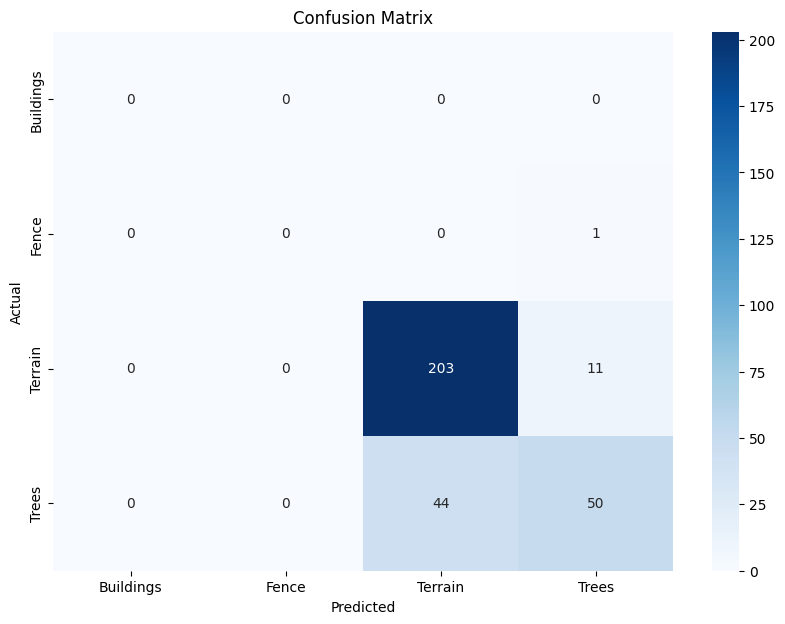

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## Visualising result

In [41]:

# Define a colormap (mapping class numbers to RGB colors)
class_colors = {
    1: [1, 0, 0],  # Buildings - Red
    2: [0, 1, 0],  # Terrain - Green
    3: [0, 0, 1],  # Cars - Blue
    4: [1, 1, 0],  # Trees - Yellow
}


# Function to visualize voxel grid with color based on classification
def visualize_voxel_grid_with_colors(voxel_grid, voxel_features, save_result_path):
    # Create a point cloud for visualization
    points = []
    colors = []
    
    # Iterate through voxel grid to assign color based on classification
    for voxel in voxel_grid.get_voxels():
        voxel_center = voxel.grid_index
        voxel_center_coords = np.array(voxel_grid.origin) + np.array(voxel_center) * voxel_size + voxel_size / 2
        
        # Retrieve the classification for this voxel (from voxel_features)
        classification = voxel_features.get(tuple(voxel.grid_index), None)
        if classification is not None:
            color = class_colors.get(classification, [0.5, 0.5, 0.5])  # Default color is gray
            points.append(voxel_center_coords)
            colors.append(color)
    
    # Create Open3D point cloud from the list of points and colors
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])
    o3d.visualization.Visualizer().destroy_window()

# Create a sample voxel grid (replace this with your actual voxel grid)
# Ensure this is your voxel grid object from Open3D
voxel_grid = o3d.geometry.VoxelGrid()  
# Load your voxel grid here...
save_result_path = "/Users/Rebekka/GiHub/3dFinalProject/results/voxel_classification_final.ply"
# Visualize voxel grid with classification colors
visualize_voxel_grid_with_colors(voxel_grid, voxel_features, save_result_path)


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


### Visualising plot of training set

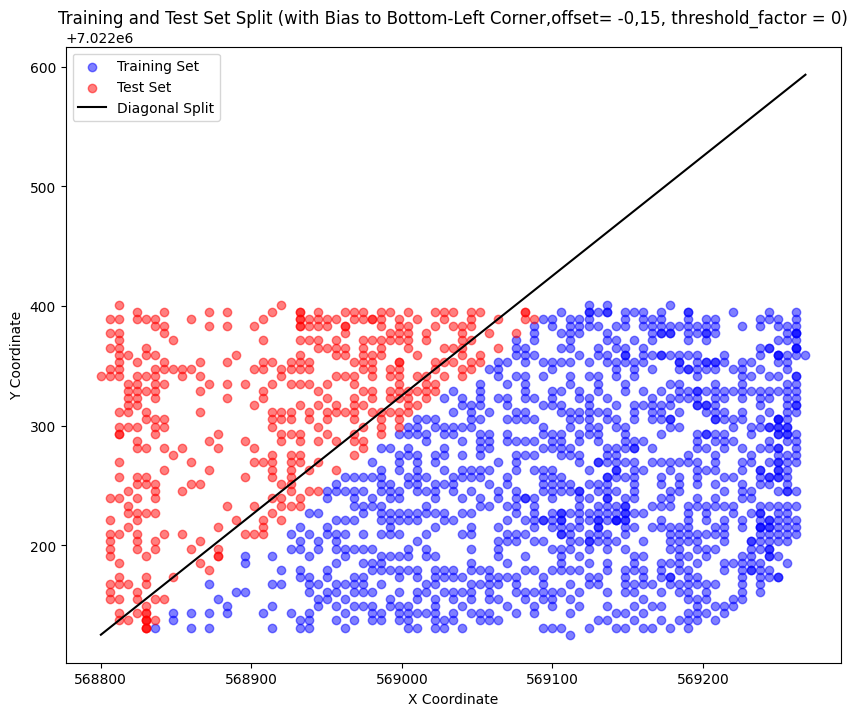

In [39]:
import matplotlib.pyplot as plt

# Step 5: Visualization
plt.figure(figsize=(10, 8))

# Convert voxel indices to coordinates and plot the training set
plt.scatter(
    [v[0] * voxel_size + x_min for v in training_indices],
    [v[1] * voxel_size + y_min for v in training_indices],
    c='blue', label='Training Set', alpha=0.5
)

# Convert voxel indices to coordinates and plot the test set
plt.scatter(
    [v[0] * voxel_size + x_min for v in test_indices],
    [v[1] * voxel_size + y_min for v in test_indices],
    c='red', label='Test Set', alpha=0.5
)

# Plot diagonal line (or modified diagonal)
x_vals = np.linspace(x_min, x_max, 100)
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, color='black', label='Diagonal Split')

# Add labels and title with threshold_factor
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Training and Test Set Split (with Bias to Bottom-Left Corner,offset= -0,15, threshold_factor = {threshold_factor})')

# Display the legend
plt.legend()

# Save the plot to a file
plt.savefig("training_test_split_plot-changed_voz_4_.png")

# Show the plot
plt.show()


### Other1: Training data on classification

In [42]:

# Drop rows with NaN in the target variable (classification)
df_cleaned = df.dropna(subset=['classification'])

# Recalculate training and test indices using cleaned data
features_df_cleaned = pd.DataFrame.from_dict(voxel_features, orient='index')
X_cleaned = features_df_cleaned.drop(columns=['classification'])
y_cleaned = features_df_cleaned['classification']



In [43]:
# Train-test split based on the cleaned data
X_train = X_cleaned.loc[training_indices]
y_train = y_cleaned.loc[training_indices]
X_test = X_cleaned.loc[test_indices]
y_test = y_cleaned.loc[test_indices]



In [44]:
X_train

,,,linearity,planarity,scattering,omnivariance,sum_of_eigenvalues,anisotropy,eigenentropy,change_of_curvature,residual
50,20,4,0.786402,0.213598,1.713899e-20,8.640898e-07,6.804133,1.000000,-9.881305,1.412246e-20,1.933318
74,11,8,0.733857,0.260322,5.821403e-03,3.900878e-01,4.288017,0.994179,-3.922406,4.576703e-03,1.590089
23,7,2,0.615057,0.384509,4.337612e-04,2.533954e-01,6.375058,0.999566,-8.024498,3.130998e-04,1.857756
59,9,3,0.615354,0.384646,1.144090e-20,2.400297e-07,2.028133,1.000000,-0.235788,8.262693e-21,0.988174
53,20,3,0.893333,0.106667,9.276226e-21,2.565569e-07,2.849267,1.000000,-2.079943,8.382127e-21,1.310124
...,...,...,...,...,...,...,...,...,...,...,...
46,7,2,0.945691,0.054309,1.477103e-35,5.777750e-12,6.555900,1.000000,-10.997020,1.401015e-35,2.036041
62,32,2,0.720968,0.279032,2.285865e-22,1.071920e-07,3.431433,1.000000,-2.430863,1.787183e-22,1.337370
64,38,2,0.763643,0.236357,9.960016e-21,1.549691e-06,14.402767,1.000000,-31.390855,8.055935e-21,2.786797
74,40,7,0.870356,0.129644,2.987115e-19,4.079956e-07,1.362267,1.000000,0.064318,2.644297e-19,0.896633


In [45]:
# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict the classes for the test set
y_pred = clf.predict(X_test)

In [46]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Mapping for class labels (you can modify this based on your actual class names)
class_labels = {
    0: 'Chimney',
    1: 'Low vegetation',
    2: 'Impervious surfaces',
    3: 'Car',
    4: 'Fence/Hedge',
    5: 'Building',
    6: 'Water',
    7: 'Farm/Soil',
    8: 'Tree'
}

# Create target_names dynamically based on unique classes
target_names = [class_labels[class_idx] for class_idx in unique_classes]

# Now print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report:
                     precision    recall  f1-score   support

     Low vegetation       0.09      0.19      0.12        36
Impervious surfaces       0.10      0.18      0.13        34
        Fence/Hedge       0.00      0.00      0.00         6
           Building       0.00      0.00      0.00         1
          Farm/Soil       0.74      0.39      0.51       255
               Tree       0.45      0.77      0.57        82

           accuracy                           0.43       414
          macro avg       0.23      0.26      0.22       414
       weighted avg       0.56      0.43      0.45       414



/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [47]:
# Save to CSV
training_set.to_csv("training_set.csv", index_label="voxel_id")
test_set.to_csv("test_set.csv", index_label="voxel_id")


NameError: name 'training_set' is not defined

In [ ]:
print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")
print(df.head())

x_min: 568800.14, x_max: 569268.19
y_min: 7022124.96, y_max: 7022399.97
           x           y       z  classification  intensity
0  569262.78  7022239.13  212.17               8      47775
1  569025.65  7022374.57  166.45               7      49500
2  569144.93  7022133.95  176.99               2      40413
3  568991.14  7022140.80  169.77               7      48102
4  569017.82  7022268.13  175.62               2      43995


In [48]:
# Print unique classes and their counts in the classification column
print("Unique classes in classification column with their counts:")
print(df['classification'].value_counts())

Unique classes in classification column with their counts:
classification
8    3548
7    3361
1    1810
2    1157
5      92
4      30
3       2
Name: count, dtype: int64


In [49]:
#  Create DataFrames for training and test sets
features_df = pd.DataFrame.from_dict(voxel_features, orient='index')

features_df['is_training'] = features_df.index.map(lambda idx: idx in training_indices)
training_set = features_df[features_df['is_training']]
test_set = features_df[~features_df['is_training']]
classification_summary = features_df.groupby(['classification', 'is_training']).size().unstack(fill_value=0)
print(features_df.head())
print("Classification Summary (Grouped by Training/Test):")
print(classification_summary)

         linearity  planarity    scattering  omnivariance  sum_of_eigenvalues  \
50 20 4   0.786402   0.213598  1.713899e-20  8.640898e-07            6.804133   
74 11 8   0.733857   0.260322  5.821403e-03  3.900878e-01            4.288017   
11 34 3   0.721414   0.278586  6.262639e-08  1.463644e-02            7.215392   
23 7  2   0.615057   0.384509  4.337612e-04  2.533954e-01            6.375058   
59 9  3   0.615354   0.384646  1.144090e-20  2.400297e-07            2.028133   

         anisotropy  eigenentropy  change_of_curvature  residual  \
50 20 4    1.000000     -9.881305         1.412246e-20  1.933318   
74 11 8    0.994179     -3.922406         4.576703e-03  1.590089   
11 34 3    1.000000    -10.476725         4.898099e-08  2.057291   
23 7  2    0.999566     -8.024498         3.130998e-04  1.857756   
59 9  3    1.000000     -0.235788         8.262693e-21  0.988174   

         classification  is_training  
50 20 4               8         True  
74 11 8               8   

## Other

In [13]:
'''
def voxelize_with_constraints(pcd, voxel_size=1.0, max_depth=5, max_points_per_voxel=50):
    # Create an empty octree with the specified max depth
    octree = o3d.geometry.Octree(max_depth=max_depth)
    octree.convert_from_point_cloud(pcd, size_expand=voxel_size)

    # Traverse the octree and apply constraints
    def traverse_and_apply_constraints(node, depth):
        if isinstance(node, o3d.geometry.OctreeInternalNode):
            # Access children directly using the node.children list
            for child in node.children:
                if child is not None:  # Check if child exists
                    traverse_and_apply_constraints(child, depth + 1)
        elif isinstance(node, o3d.geometry.OctreeLeafNode):
            if len(node.indices) > max_points_per_voxel:
                print(f"Voxel at depth {depth} with {len(node.indices)} points exceeds max points threshold.")

    traverse_and_apply_constraints(octree.root_node, depth=0)
    return octree

# Apply constrained voxelization
voxel_size = 1.0       # Minimum voxel size
max_depth = 5          # Maximum depth of the octree
max_points_per_voxel = 100  # Maximum points allowed in a voxel

octree = voxelize_with_constraints(pcd, voxel_size, max_depth, max_points_per_voxel)
'''

Voxel at depth 5 with 123 points exceeds max points threshold.
Voxel at depth 5 with 145 points exceeds max points threshold.
Voxel at depth 5 with 106 points exceeds max points threshold.
Voxel at depth 5 with 110 points exceeds max points threshold.
Voxel at depth 5 with 105 points exceeds max points threshold.
Voxel at depth 5 with 103 points exceeds max points threshold.
Voxel at depth 5 with 145 points exceeds max points threshold.


In [ ]:
#Visualising octtree
#o3d.visualization.draw_geometries([octree], window_name="Constrained Voxelized Octree")


In [ ]:
#Visualising voxel
#o3d.visualization.draw_geometries([voxel_grid], window_name="Voxel Grid Visualization", width=800, height=600)


In [12]:
# Step 2 & 3: Feature Selection and Calculation
# Extract voxel-based features: mean, std dev of intensity within each voxel
df['voxel_id'] = df[['x', 'y', 'z']].apply(lambda row: tuple(voxel_grid.get_voxel(np.array(row))), axis=1)

# Group by voxel ID and calculate desired statistics
voxel_features = df.groupby('voxel_id').agg({
    'intensity': ['mean', 'std'],
    'x': 'mean', 'y': 'mean', 'z': 'mean'
}).fillna(0)

# Flatten the MultiIndex columns
voxel_features.columns = ['_'.join(col) for col in voxel_features.columns]

In [14]:
features = voxel_features
labels = df.groupby('voxel_id')['classification'].first()

In [15]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Initialize and train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate classifier
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.83      0.84       441
           2       0.89      0.89      0.89       259
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       1.00      0.62      0.76        26
           7       0.94      0.97      0.95       771
           8       0.94      0.94      0.94       882

    accuracy                           0.92      2386
   macro avg       0.66      0.61      0.63      2386
weighted avg       0.91      0.92      0.92      2386



/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Other 2

# The classes need to be labeled for TBA-4256
# scalar field name: class
########
0 Chimney
1 Low vegetation
2 Impervious surfaces
3 Car
4 Fence/Hedge
5 Building
6 Water
7 Farm/Soil
8 Tree